<font size="-1">FALL 2022 
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="60px" align="right">
 </br>
<font size="-01">MATH 404: Linear and Non-Linear Programming</font>

<font size="-1">University of Science and Technology, Zewail City</font>

<br>

<h1 align="center">Research Report 3 Implementation: </h1>
<h2 align="center">Unconstrained Nonlinear Optimization</h2>
<h2 align="center">Done by: Abdelrahman Elaraby - 201700556</h2>

---


<br> <br> <br>

In this report I will re-implement Some Unconstrained Optimization Algorithms for Non-Linear functions. These Optimization Algorithms have an internal subproblem which is a 1D-minimzation line search problem; So, I will implement at first 4 of the famous 1D search techniques:
*  The Fibonacci method.
*  The golden section method.
*  The quadratic interpolation method.
*  The cubic interpolation method.<br>

After the 1D, I will implement 3 Algorithms:
*   Fletcher Reeves CG Method
*   Marquardt Method
*   Quasi-Newton Method (BFGS)<br>

I will compare the above algorithms interms of Number of iterations, The optimal solution, The optimal value, and CPU time.





# Imports and Libraries:

In [1]:
import math
import numpy as np
import random
from scipy import optimize
from matplotlib import pyplot
from autograd import grad, hessian
from mpl_toolkits import mplot3d
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
from numpy import inf

# The 1D-Minimization Algorithms:

Implementation and testing order:


*   The Fibonacci method.
*   The golden section method.
*   The quadratic interpolation method.
*   The cubic interpolation method.



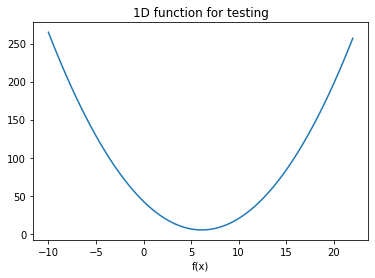

In [2]:
# all the 1D algorithms will be tested on the following unimodal 1Dfunction
f = lambda x: (x - 6.123)**2 + 5
# clearly the minimum is at x = 6.123, but also let's plot it
x = np.linspace(-10, 22, 100)
y = f(x)
plt.plot(x, y)
plt.title("1D function for testing")
plt.xlabel("x")
plt.xlabel("f(x)")
plt.show()

In [3]:
optimize.minimize_scalar(f) # check optimal with ready-made function

     fun: 5.0
    nfev: 10
     nit: 4
 success: True
       x: 6.123000000000001

In [4]:
# the Fibonnaci Method, its natrure is recursive, so i will implement it using recursion

def fibonacci_method(f, a, b, err=1e-5):
    '''
    Fibonnaci Method
    it takes a 1D function and an interval [a, b] to find the minimum

    INPUTS:
    f: a 1D function
    a,b: interval points [a, b] 
    err: stopping criteria


    RETURNS:
    x: the solution point (minimum)
    '''
    # internal helping function,
    # the Fibonacci function that will return the fibonacci value at a given index
    def fib(i):
        if i == 0:
            return 0
        elif i == 1:
            return 1
        else:
            return fib(i-1)+fib(i-2)

    needed_fib = (b-a)/err # find the needed fib number

    # find the index of that fib number
    i = 1
    fib_num = fib(i)
    while fib_num < needed_fib:
      i += 1 # check the next
      fib_num = fib(i)
    i = i + 1 # adjust the index, to be for the one responsible exiting the loop

    # main loop of fibonacci search
    for j in range(1, i-1):
      L0 = b-a # the existing full length

      r1 = fib(i-j-1)/fib(i-j+1) # ratio for x1
      x1 = a+ r1*L0 # compute x1

      r2 = fib(i-j)/fib(i-j+1) # ratio for x2
      x2 = a+ r2*L0 # compute x2

      # check which is lower to update the ends a and b
      if f(x2) > f(x1):
        b = x2
      else:
        a = x1
    # return the average of the 2 ends
    return (a+b)/2

In [5]:
# Testing of Fibonnaci Method
opt = fibonacci_method(f, -10, 10)
print(f'Solution found by fibonacci_method: {opt}')

Solution found by fibonacci_method: 6.123005364046421


In [6]:
# the Golden Section Method, its natrure is recursive, so i will implement it using recursion

def golden_section_method(f, a, b, err=1e-5, L0=0, x1=0, x2=0, fx1=0, fx2=0):
    '''
    Golden Section Method
    it takes a 1D function and an interval [a, b] to find the minimum

    INPUTS:
    f: a 1D function
    a,b: interval points [a, b] 
    err: stopping criteria
    L0,x1,x2,fx1,fx2: internal variables for recursion purposes

    RETURNS:
    x: the solution point (minimum)
    '''

    golden_r1 = (math.sqrt(5) - 1) / 2  # golden ration
    golden_r2 = (3 - math.sqrt(5)) / 2  # 1 - golden_r1, for the other point

    if L0 == 0: # for initial start
        L0 = b - a # the existing length

    if L0 <= err: # base condition, if optimal then exit
        return (a+b)/2

    # update the internal points x1 and x2
    if x1 == 0:
        x1 = a + golden_r2*L0
    if x2 == 0:
        x2 = a + golden_r1*L0

    # update the function value of the internal points f(x1) and f(x2) 
    if fx1 == 0:
        fx1 = f(x1)
    if fx2 == 0:
        fx2 = f(x2)

    # do the process again but with updated points
    if fx1 < fx2:
        return golden_section_method(f, a, x2, err, L0*golden_r1, x1=0, fx1=0, x2=x1, fx2=fx1)
    else:
        return golden_section_method(f, x1, b, err, L0*golden_r1, x1=x2, fx1=fx2, x2=0, fx2=0)

In [7]:
# Testing of Golden Section Method
opt = golden_section_method(f, -10, 10)
print(f'Solution found by Golden Section Method: {opt}')

Solution found by Golden Section Method: 6.1229990132044465


In [8]:
# Quadratic Interpolation Method

def quadratic_interpolation(f, t, err =1e-5):
    '''
    Quadratic Interpolation Method
    it takes a 1D function and an probe value t, to find the minimum

    INPUTS:
    f: a 1D function
    t: probe value
    err: stopping criteria

    RETURNS:
    x: the solution point (minimum)
    '''

    # calculate the testing points
    A = 0
    B = t
    C = 2*t

    # calculate the function values at testing points
    fa = f(A)
    fb = f(B)
    fc = f(C)

    # initialize f1
    f1 = f(B)

    # calculate the model parameters
    a = fa
    b = (4*fb-3*fa-fc )/(2*t)
    c = (fc+fa-2*fb )/(2*(t**2))

    quad_model = lambda lamda : a+b*lamda+c*(lamda**2) # the quadratic model

    # adjust t value
    if f1 > fa:
        fc = f1
        fb = f(t/2)
        t = t/2
    while f1 < fa:
        fb = f1
        f2 = f(2*t)

        if f1 < f2:
            fc = f2
            break         
        elif f1 > f2:
            f1 = f2
            t = 2*t

    # calculate lambda star 
    lamda_star = (-1*b)/(2*c)


    hi = quad_model(lamda_star)
    fi = f(lamda_star)
    # if difference between true function and model is large, re-do
    while abs((hi-fi)/fi) > err:
        # update model parameters
        a = fa
        b = (4*fb-3*fa-fc )/(2*t)
        c = (fc+fa-2*fb )/(2*(t**2))
        
        # adjust the points according to which is lower
        if (lamda_star>B and f(lamda_star)<fb):
            A = B
            B = lamda_star
        elif (lamda_star>B and f(lamda_star)>fb):
            C = lamda_star
        elif (lamda_star<B and f(lamda_star)<fb):
            B = lamda_star
            C = B
        elif (lamda_star<B and f(lamda_star)>fb):
            A=lamda_star

        # update the function values at the test points
        fa = f(A)
        fb = f(B)
        fc = f(C)
    
        # to break instead of dividing by zero error
        if( (2*(fa*(B-C)+fb*(C-A)+fc*(A-B))) == 0):
            break

        # re-estimate lamda star
        lamda_star = (fa*(B**2-C**2)+fb*(C**2-A**2)+fc*(A**2-B**2))/(2*(fa*(B-C)+fb*(C-A)+fc*(A-B)))

        # if there is no change, break the loop
        old_lamda = lamda_star
        if (lamda_star==old_lamda):
            break

        # if difference between true function and model is large, re-do
        hi = quad_model(lamda_star)
        fi = f(lamda_star)

    return lamda_star    

In [9]:
# Testing of Quadratic Interpolation Method
opt = quadratic_interpolation(f, 0.05)
print(f'Solution found by Quadratic Interpolation Method: {opt}')

Solution found by Quadratic Interpolation Method: 6.123000000005439


In [10]:
def cubic_interpolation(f, t, err=1e-5):
    '''
    Cubic Interpolation Method
    it takes a 1D function and an probe value t, to find the minimum

    INPUTS:
    f: a 1D function
    t: probe value
    err: stopping criteria

    RETURNS:
    x: the solution point (minimum)
    '''
    # compute the gradient (using Automatic Derivative ready-made)
    df = grad(f)

    # testing points
    A=0
    B=t

    # function values and their derivatives at testing points
    fa=f(A)
    fb=f(B)

    df_a=df(float(A))
    df_b=df(float(B))


    # change the interval till f'(A)<0 and f'(B)>0
    while (df_b<0):
        fa = fb
        df_a = df_b
        A = t
        t = 2*t
        
        fb = f(t)
        df_b = df(float(t))
    
    # formulas for calculating lamda star
    Z = 3*(fa-fb)/(B-A) + df_a+df_b
    Q = np.sqrt(Z**2-df_a*df_b)

    lamda_star = A+(B-A)*((df_a+Z+Q)/(df_a+df_b+2*Z))

    B = t # adjust the second point
    while (True):
        #construct Z,Q
        Z=3*(fa-fb)/(B-A) +df_a+df_b
        Q = np.sqrt(Z**2-df_a*df_b)

        # for comparing
        lamda_old = lamda_star

        # calculate new lamda
        lamda_star=A+(B-A)*((df_a+Z+Q)/(df_a+df_b+2*Z))

        # exit if no change
        if (lamda_star == lamda_old):  
            break

        #calculate model parameters using the formulas  
        b=(1/(A-B)**2)*((B**2)*df_a+(A**2)*df_b+2*A*B*Z)
        c=-(1/(A-B)**2)*((A+B)*Z+B*df_a+A*df_b)
        d=(1/(3*(A-B)**2))*(2*Z+df_a+df_b)
        a=fa-b*A-c*(A**2)-d*(A**3)

        # Cubic model at current lamda
        hi = a +b*lamda_star +c*(lamda_star**2) +d*(lamda_star**3)

        # true function value at current lamda
        fi = f(lamda_star)

        #current derrivative
        df_i = df(lamda_star)


        # test for Convergence
        if abs((hi-fi)/fi) < err:
            break

        # update point values 
        if (df_i > 0):
            A = lamda_star
            fa = fi
            df_a = df_i
        else:
            B = lamda_star
            fb = fi
            df_a = df_i
        
    return lamda_star

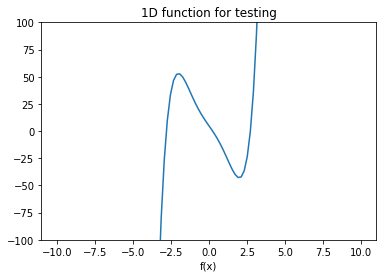

In [11]:
# for the cubic method, we need a higher order function than quadratic
f = lambda x: x**5 - 5*x**3 - 20*x +5
# also let's plot it
x = np.linspace(-10, 10, 100)
y = f(x)
plt.plot(x, y)
plt.title("1D function for testing")
plt.xlabel("x")
plt.xlabel("f(x)")
plt.ylim(ymax=100, ymin=-100)
plt.show()

In [12]:
optimize.minimize_scalar(f) # check optimal with ready-made function

     fun: -42.99999999999999
    nfev: 13
     nit: 9
 success: True
       x: 2.0000000140627363

In [13]:
# Testing of Cubic Interpolation Method
opt = cubic_interpolation(f, 0.5)
print(f'Solution found by Cubic Interpolation Method: {opt}')
print(f'function value: {f(opt)}')

Solution found by Cubic Interpolation Method: 2.0
function value: -43.0


# Implementation of the 3 methods:

Implementation order:


*   Fletcher Reeves CG Method
*   Marquardt Method
*   Quasi-Newton Method (BFGS)



In [14]:
def fletcher_reeves(f, x1, epsilon):
    '''
    Fletcher Reeves CG Method
    it takes a non-linear function and an initial point and finds the minimum

    INPUTS:
    f: non-linear function (as a lambda or python function)
    x1: initial point
    epsilon: stopping criteria (if gradient <= epsilon)


    RETURNS:
    xi: the solution point (minimum)
    fi: function value at the minimum
    
    '''
    s0=np.zeros(x1.shape[0]) # dummy variable for evaluation of the objective function
    # set the first search direction to be be steepest descent 
    grad_1 = grad(f)(x1, 0, s0)
    s1= -1*grad_1

    # initialize the loop index and the variables
    i = 1
    xi = x1
    si = s1
    grad_i = grad_1
    while np.linalg.norm(grad_i) > epsilon:
        # move to the new point
        one_D_problem = lambda alpha : f(xi,alpha,si) # 1D problem to compute optimal alpha (step length)
        alpha_opt = optimize.minimize_scalar(one_D_problem, method='golden').x
        xi_1 = xi
        xi = xi_1 + alpha_opt*si

        # calculate the new direction
        norm_squared_gi = np.linalg.norm(grad(f)(xi, 0, s0))**2
        norm_squared_gi_1 = np.linalg.norm(grad(f)(xi_1, 0, s0))**2
        beta_i = norm_squared_gi/norm_squared_gi_1 # the beta term to make new conjugate direction
        si_1 = si
        grad_i = grad(f)(xi, 0, s0)
        si = -1*grad_i + beta_i * si_1 # new direction

        i = i+1 # update the loop index
      

    print(f'Number of iterations: {i-1}')
    return xi, f(xi, 0, s0)


In [15]:
def marquardt_method(f, x1, alpha, c1, c2, epsilon):
    '''
    Marquardt Hybrid method
    it takes a non-linear function and an initial point and finds the minimum

    INPUTS:
    f: non-linear function (as a lambda or python function)
    x1: initial point
    alpha: mixing term (between alpha and inverse hessian)
    c1, c2: scaling terms for alpha
    epsilon: stopping criteria (if gradient <= epsilon)


    RETURNS:
    xi: the solution point (minimum)
    fi: function value at the minimum
    
    '''
    s0=np.zeros(x1.shape[0]) # dummy variable for evaluation of the objective function
    # set the first search direction to be be steepest descent 
    grad_1 = grad(f)(x1, 0, s0)
    H = hessian(f)
    I = np.identity(x1.shape[0])
    s1 = -1 * np.linalg.inv(H(x1, 0, s0)+ alpha*I)@grad_1

    # initialize the loop index and the variables
    i = 1
    xi = x1
    si = s1
    grad_i = grad_1
    while np.linalg.norm(grad_i) > epsilon:
        fi1= f(xi,0,s0) # evaluate objective function
        # move to the new point
        one_D_problem = lambda alpha : f(xi,alpha,si) # 1D problem to compute optimal alpha (step length)
        lam_opt = optimize.minimize_scalar(one_D_problem, method='golden').x
        xi_1 = xi
        xi = xi_1 + lam_opt*si
        fi2= f(xi,0,s0) # evaluate objective function after moving

        # check whether the function increased or decreased to adjust alpha
        if fi2 > fi1:
            alpha = c2*alpha
        else:
            alpha = c1*alpha

        # calculate the new direction  
        grad_i = grad(f)(xi, 0, s0)
        si = -1 * np.linalg.inv(H(xi, 0, s0)+ alpha*I)@grad_i # new direction

        i = i+1 # update the loop index
    
    print(f'Number of iterations: {i-1}')
    return xi, f(xi, 0, s0)


In [16]:
def quasi_newton_BFGS_method(f, x1, epsilon):
    '''
    Quasi Newton Method, Update using BFGS
    it takes a non-linear function and an initial point and finds the minimum

    INPUTS:
    f: non-linear function (as a lambda or python function)
    x1: initial point
    epsilon: stopping criteria (if gradient <= epsilon)


    RETURNS:
    xi: the solution point (minimum)
    fi: function value at the minimum
    
    '''  
    s0=np.zeros(x1.shape[0]) # dummy variable for evaluation of the objective function
    # set the first search direction to be be steepest descent 
    grad_1 = grad(f)(x1, 0, s0)
    
    I = np.identity(x1.shape[0])
    Hi = I # first approximation of inverse hessian is identity matrix
    s1 = -1*Hi@grad_1

    # initialize the loop index and the variables
    i = 1
    xi = x1
    si = s1
    grad_i = grad_1
    while np.linalg.norm(grad_i) > epsilon:
        fi= f(xi,0,s0) # evaluate objective function
        # move to the new point
        one_D_problem = lambda alpha : f(xi,alpha,si) # 1D problem to compute optimal alpha (step length)
        alpha_opt = optimize.minimize_scalar(one_D_problem, method='golden').x
        xi_1 = xi
        xi = xi_1 + alpha_opt*si

        #### calculate the new direction using BFGS 
        # compute gradients and helping terms
        grad_i_1 = grad_i
        grad_i = grad(f)(xi, 0, s0)

        y = grad_i - grad_i_1
        s = xi - xi_1

        # update inverse hessian approximation
        t1 = I - np.outer(s,y)/(y.T@s)
        t2 = I - np.outer(y,s)/(y.T@s)
        t3 = (s@s.T)/(y.T@s)
        Hi= t1@Hi@t2 + t3

        si = -1*Hi@grad_i # new direction

        i = i+1 # update the loop index
        # break
    
    print(f'Number of iterations: {i-1}')
    return xi, f(xi, 0, s0)


# Testing of the 3 methods:

## Test Case 1: Rosenbrock’s parabolic valley function:

The function is defined as: $f(x_1,x_2) = 100(x_2-x_1^2)^2 +(1-x_1)^2$ <br>
The initial point is: $(-1.2, 1)$

At first, let's visualize the function

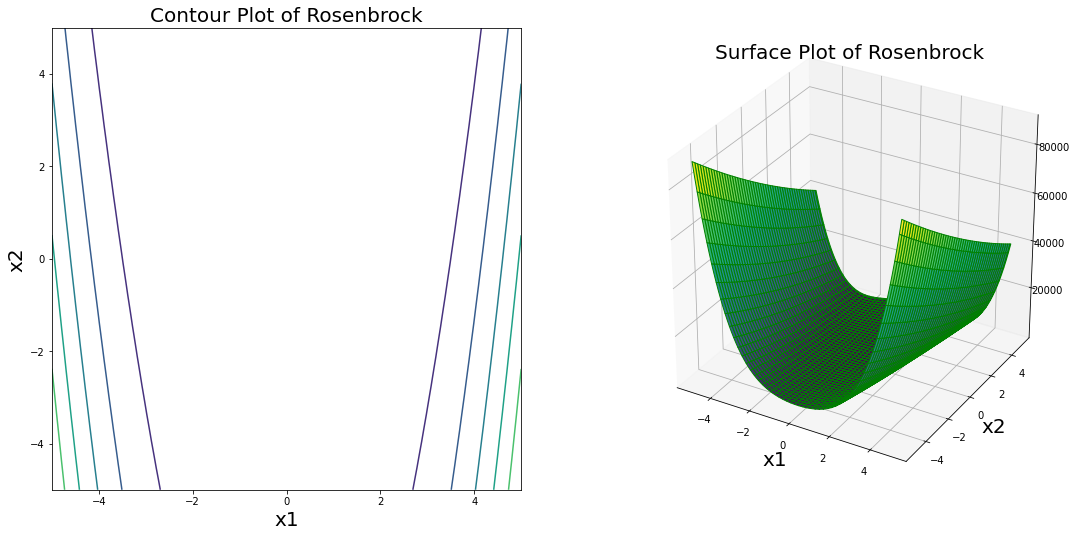

In [17]:
# visualizations
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Contour Plot 
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
f= lambda x:(100*(x[1] - x[0]**2)**2)+((1-x[0])**2)
[X, Y] = np.meshgrid(x1, x2) # Creating 2-D grid of features
Z = f([X, Y])

ax1.contour(X, Y, Z)
ax1.set_title("Contour Plot of Rosenbrock", fontsize=20)
ax1.set_xlabel("x1", fontsize=20)
ax1.set_ylabel("x2", fontsize=20)

#### Surface Plot 
# defining surface and axes
x = np.outer(np.linspace(-5, 5, 100), np.ones(100))
y = x.copy().T
z = (100*(y - x**2)**2)+((1-x)**2)

ax2.axis('off')
ax2 = fig.add_subplot(122, projection='3d')

ax2.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
ax2.set_title("Surface Plot of Rosenbrock", fontsize=20)
ax2.set_xlabel("x1", fontsize=20)
ax2.set_ylabel("x2", fontsize=20)
plt.show()

Clearly it is a difficult function, that's why it used as a bench mark problem for testing the algorithms

In [18]:
# defining the function, I defined it with embedded alpha and s (direction) to use it in the 1D minimization subproblem 
# if you just want the function value at x, put alpha and/or s = 0
def f(x,alpha,s):
    return 100*((x[1]+alpha*s[1])-(x[0]+alpha*s[0])**2)**2 + (1-(x[0]+alpha*s[0]))**2

#intial point and error tolerance
x1 = np.array([-1.2, 1])
epsilon = 1e-3

In [19]:
############## THE TESTING ##############

# Fletcher-Revees Method
print(f'------ Fletcher-Revees CG Method ------')
t0 = time.time()
res= fletcher_reeves(f, x1, epsilon)
t1 = time.time()-t0
print(f'Solution Point: {res[0]}',)
print(f'Solution Function Value: {res[1]}',)
print(f'CPU time: {t1}\n',)


# Marquardt Method
print(f'------ Marquardt Method ------')
t0 = time.time()
x_marq = marquardt_method(f, x1, alpha=2e4, c1=0.5, c2=2, epsilon=1e-3)
t1 = time.time()-t0
print(f'Solution Point: {res[0]}',)
print(f'Solution Function Value: {res[1]}',)
print(f'CPU time: {t1}\n',)


# Quasi-Newton BFGS Method
print(f'------ Quasi-Newton BFGS Method ------')
t0 = time.time()
x_quas = quasi_newton_BFGS_method(f, x1, epsilon)
t1 = time.time()-t0
print(f'Solution Point: {res[0]}',)
print(f'Solution Function Value: {res[1]}',)
print(f'CPU time: {t1}\n',)

------ Fletcher-Revees CG Method ------
Number of iterations: 114
Solution Point: [1.00020729 1.00041751]
Solution Function Value: 4.380354894594454e-08
CPU time: 0.2363431453704834

------ Marquardt Method ------
Number of iterations: 19
Solution Point: [1.00020729 1.00041751]
Solution Function Value: 4.380354894594454e-08
CPU time: 0.1172945499420166

------ Quasi-Newton BFGS Method ------
Number of iterations: 20
Solution Point: [1.00020729 1.00041751]
Solution Function Value: 4.380354894594454e-08
CPU time: 0.027920961380004883



## Test Case 2: Powell’s quartic function:

The function is defined as: $f(x_1,x_2,x_3,x_4) = (x_1+10x_2)^2 + 5(x_3-x_4)^2 + (x_2-2x_3)^4 +10(x_1-x_4)^4$ <br>
The initial point is: $(3, -1, 0, 1)$

Since it is higher than 3D, I can't visualize it easily ¯\\_(ツ)_/¯ <br>
So, I will go for solving it!

In [20]:
# defining the function, I defined it with embedded alpha and s (direction) to use it in the 1D minimization subproblem 
# if you just want the function value at x, put alpha and/or s = 0
def f(x,alpha,s):
    return ((x[0]+alpha*s[0])+(10*(x[1]+alpha*s[1])))**2 + 5*((x[2]+alpha*s[2])-(x[3]+alpha*s[3]))**2 +((x[1]+alpha*s[1])-2*(x[2]+alpha*s[2]))**4+ 10*((x[0]+alpha*s[0])-(x[3]+alpha*s[3]))**4

#intial point and error tolerance
x1 = np.array([3.0, -1.0, 0.0, 1.0])
epsilon = 1e-3

In [21]:
############## THE TESTING ##############

# Fletcher-Revees Method
print(f'------ Fletcher-Revees CG Method ------')
t0 = time.time()
res= fletcher_reeves(f, x1, epsilon)
t1 = time.time()-t0
print(f'Solution Point: {res[0]}',)
print(f'Solution Function Value: {res[1]}',)
print(f'CPU time: {t1}\n',)


# Marquardt Method
print(f'------ Marquardt Method ------')
t0 = time.time()
x_marq = marquardt_method(f, x1, alpha=2e4, c1=0.5, c2=2, epsilon=1e-3)
t1 = time.time()-t0
print(f'Solution Point: {res[0]}',)
print(f'Solution Function Value: {res[1]}',)
print(f'CPU time: {t1}\n',)


# Quasi-Newton BFGS Method
print(f'------ Quasi-Newton BFGS Method ------')
t0 = time.time()
x_quas = quasi_newton_BFGS_method(f, x1, epsilon)
t1 = time.time()-t0
print(f'Solution Point: {res[0]}',)
print(f'Solution Function Value: {res[1]}',)
print(f'CPU time: {t1}\n',)

------ Fletcher-Revees CG Method ------
Number of iterations: 159
Solution Point: [ 0.02625296 -0.00262915  0.01322802  0.01326136]
Solution Function Value: 1.0075409195853434e-06
CPU time: 0.5570478439331055

------ Marquardt Method ------
Number of iterations: 25
Solution Point: [ 0.02625296 -0.00262915  0.01322802  0.01326136]
Solution Function Value: 1.0075409195853434e-06
CPU time: 0.2387082576751709

------ Quasi-Newton BFGS Method ------
Number of iterations: 24
Solution Point: [ 0.02625296 -0.00262915  0.01322802  0.01326136]
Solution Function Value: 1.0075409195853434e-06
CPU time: 0.06169724464416504

